Zadanie polega na stworzeniu modelu rekurencyjnego, który będzie przewidywał kompozytora danego utworu muzyki klasycznej w oparciu o jego zapis w formie sekwencji akordów. Akordy znormalizowane zostały do klucza C-dur lub a-moll, w zależności od skali utworu (durowa/molowa).
Dane przygotowane są w postaci pickle (https://docs.python.org/3/library/pickle.html), w których znajduje się lista krotek z sekwencjami i odpowiadającymi im klasami (kompozytorami), odpowiednio: {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}. Dane treningowe znajdują się w pliku train.pkl. W pliku test_no_target.pkl znajdują się testowe sekwencje, dla których predykcje mają Państwo przewidzieć.

Uwaga, utwory mogą mieć różne długości. Do stworzenia batchy dla przykładów różnej długości proszę wykorzystać omówiony na zajęciach padding i trenować z wykorzystaniem spaddowanych tensorów lub spakowanych sekwencji (PackedSequence).

Bardzo proszę, żeby zwrócili Państwo archiwum zip, zgodnie z instrukcjami:
- Archiwum powinno być nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.zip (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- W archiwum proszę bez zbędnych podfolderów umieścić pliki ze swoim kodem i testowe predykcje nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.csv (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- Testowe predykcje powinny mieć kolejność zgodną z kolejnością sekwencji w picklu. Plik csv. nie powinien mieć nagłówka ani indeksów.

Proszę zwracać uwagę na prawidłowe nazewnictwo oraz odpowiedni format zwracanych plików. Niedostosowanie się do wytycznych może spowodować nieuwzględnienie Państwa w rankingu i utratę punktów za osiągnięty wynik!

In [1]:
# !pip install GPUtil
#
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda
#
# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()
#
#     torch.cuda.empty_cache()
#
#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)
#
#     print("GPU Usage after emptying the cache")
#     gpu_usage()
#
# free_gpu_cache()
#
# import sys
# torch.cuda.empty_cache()
# sys.modules[__name__].__dict__.clear()
# !nvidia-smi

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

Prepare dataset


In [4]:
import pickle

In [5]:
file = open('train.pkl', 'rb')
train = pickle.load(file)
file.close()

In [39]:
test_file = open('test_no_target.pkl', 'rb')
test_no_target = pickle.load(test_file)
test_file.close()

In [6]:
train

[(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0),
 (array([ -1.,  -1., 144., ...,  32.,  -1.,  -1.]), 0),
 (array([ 66., 100., 148., 148., 146.,  64., 146., 148.,  82.,   0.,  82.,
         100.,  34., 132., 180.,  65.,  80.,  81., 131.,  52.,  34.,  52.,
          64.,  52.,   3.,  66., 147.,  20.,   4., 132., 132., 100., 111.,
          74., 110.,  60.,  92.,  65., 100., 189.,  44.,   8.,   5.,  76.,
          31., 159.,   5., 124.,   4.,  12.,  51., 157.,  57.,  31., 183.,
          57.,  65.,  92.,  69., 124., 122.,  79., 110.,  76.,  12.,  12.,
          12.,  12.,   8., 159.,  12., 156., 100., 111.,  52., 121.,  36.,
          47.,  41.,  41.,   8., 172.,  38.,  12.,  78.,  12.,  88.,  47.,
         119.,  20.,  47.,  12., 159.,  20.,  20.,  76.,  60., 110., 132.,
         185., 120.,  45., 110., 110.,  72., 124., 178.,  73.,   8.,  78.,
          12.,  42., 173.,  12., 150.,  84.,  66., 152.,  69.,   8.,  41.,
         159.,   5.,  78.,  44., 180.,  71.,  92., 152.,   6., 

In [40]:
test_no_target

[array([  0.,   0.,   0.,   0.,  88.,  88.,  88.,  88.,  69., 145., 145.,
        145.,   5.,   5.,   5.,   5.,  92.,  88.,  88.,  80.,  45.,  39.,
        190., 190., 124., 112., 112., 112.,  77.,  36.,  36.,  36.,  20.,
         20.,  13., 158., 127.,  55.,  55., 113., 127., 151.,  22., 116.,
        144., 144.,  34.,  68.,  33.,  33.,  33.,  41.,  41.,  47.,  47.,
        180.,  12., 119.,  37., 100., 112., 112.,   2.,  36.,   0.,   0.,
          0.,   0.,  88.,  88., 120., 120.,  12.,   5.,  13.,  13.,  92.,
        149.,  32.,   4.,  12.,  37.,  12., 159.,  13.,   6., 124.,  37.,
        124.,  37.,  37.,   8.,   8., 119.,  78.,  73.,  12.,   0.,   0.,
          0.,  88.,  88.,  88.,  88.,  69., 145., 145., 145.,   5.,   5.,
          5.,   5.,  92.,  88.,  88.,  80.,  45.,  39., 190., 190., 124.,
        112., 112., 112.,  77.,  36.,  36.,  36.,  20.,  20.,  13., 158.,
        127.,  55.,  55., 113., 127., 151.,  22., 116., 144., 144.,  34.,
         68.,  33.,  33.,  33.,  41., 

(30, 5322)


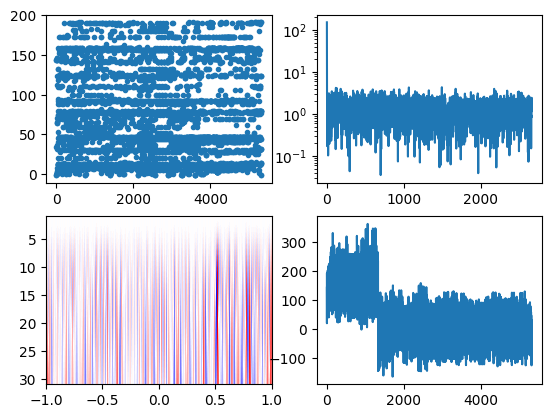

In [8]:
import pywt
from scipy.fft import fft, fftfreq
from scipy import signal

def flatten_list(l):
    return [item for sublist in l for item in sublist]
#choosen_sample = np.delete(train[200][0],[0])
choosen_sample =train[1][0] # orginal signal
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
N = len(choosen_sample)
T = 1.0 / len(choosen_sample)

ax1.plot(choosen_sample,'.')

yfreq = fft(choosen_sample) # Fourier transform
xfreq = fftfreq(N, T)[:N//2]
ax2.semilogy(xfreq, 2.0/N * np.abs(yfreq[0:N//2]))

widths = np.arange(1, 31)
wavelet = signal.ricker # only option unfortunately
#cwtmatr = signal.cwt(choosen_sample , wavelet, widths) # Continuous Wavelet Transform

cwtmatr, freqs = pywt.cwt(choosen_sample, widths, 'mexh') # Continuous Wavelet Transform # 'gaus1'
print(cwtmatr.shape)

coeffArray = pywt.wavedec(choosen_sample,'db1',level=2)  # Multilevel discrete Wavelet transform
#print(coeffArray)
ax3.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='seismic', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

# cwtmatr_sum = cwtmatr[0][:]
# for i in range(1,len(cwtmatr)-1):
#     cwtmatr_sum += cwtmatr[i][:]
#
# ax3.plot(cwtmatr_sum)
#
# print(cwtmatr_sum.shape)
dwt_coeffs = flatten_list(coeffArray)

ax4.plot(dwt_coeffs)


plt.show()

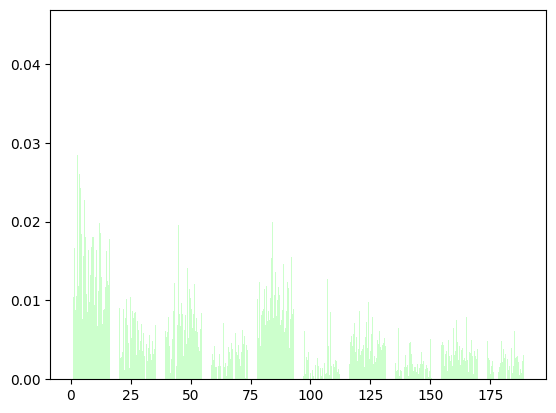

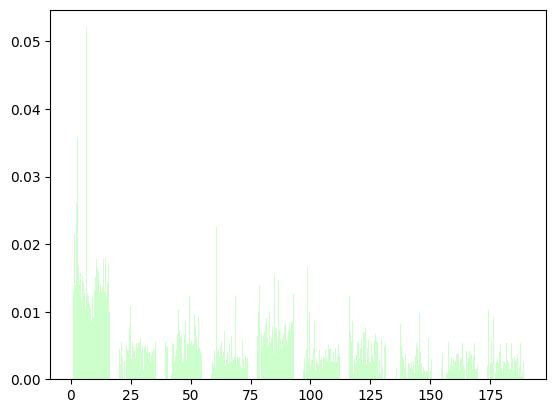

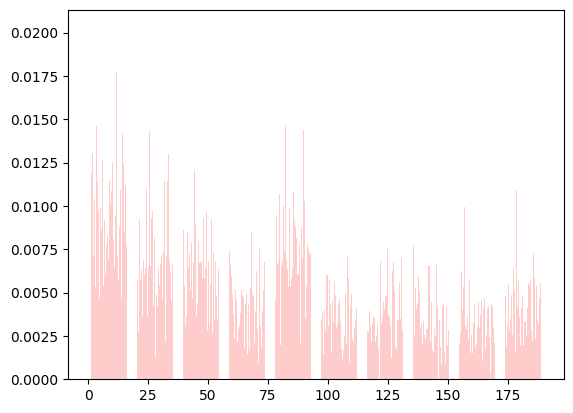

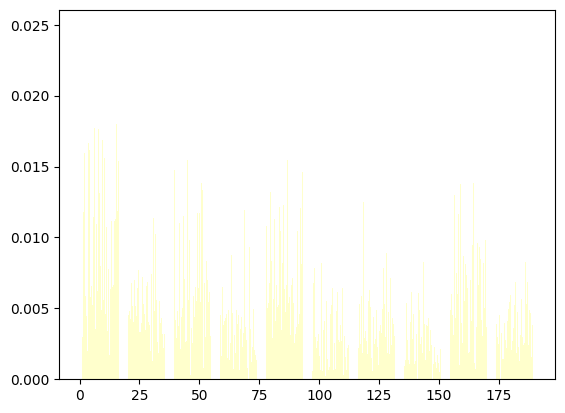

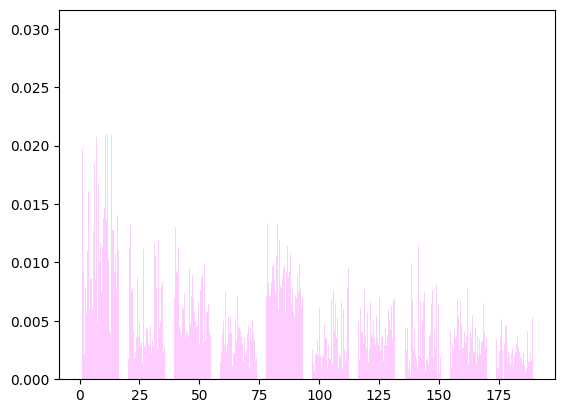

In [9]:
# train_x0 = []
# train_x1 = []
# train_x2 = []
# train_x3 = []
# train_x4 = []
#
# for i in range(0,len(train[:])):
#     if train[i][1] == 0:
#         train_x0.append(train[i][0])
#     elif train[i][1] == 1:
#         train_x1.append(train[i][0])
#     elif train[i][1] == 2:
#         train_x2.append(train[i][0])
#     elif train[i][1] == 3:
#         train_x3.append(train[i][0])
#     else:
#         train_x4.append(train[i][0])
#
#
#
# plt.hist(train_x0[:],density=True,lw=3,fc=(0, 1, 0, 0.2))
# plt.show()
# plt.hist(train_x1[:],density=True,lw=3,fc=(0, 1, 0, 0.2))
# plt.show()
# plt.hist(train_x2[:],density=True,lw=3,fc=(1, 0, 0, 0.2))
# plt.show()
# plt.hist(train_x3[:],density=True,lw=3,fc=(1, 1, 0, 0.2))
# plt.show()
# plt.hist(train_x4[:],density=True,lw=3,fc=(1, 0, 1, 0.2))
# plt.show()

In [10]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [11]:
import random
from scipy import signal
from random import sample
import itertools
def swapNresample(list_set, std):
    sampled_list = sample(list_set, 1) # one sample
    compositor = sampled_list[0][1] # target
    sampled_list = sampled_list[0][0]
    l = int(len(sampled_list)/4)

    #print(sampled_list )
    r1_a = int(round(random.uniform(5,int(l/2)-1),0))
    r1_b = int(round(random.uniform(int(l/2),l-5),0))

    if r1_a > r1_b:
        r1_c = r1_a
        r1_a = r1_b
        r1_b = r1_c
        l_off = r1_b
    else:
        l_off = r1_a

    offset = int(round(random.uniform(2,l_off-1),0))
    r2_a = r1_a - offset
    r2_b = r1_b - offset

    if r2_a <= -1 or r2_b <= -1 or r1_a <= -1 or r1_b <= -1:
        off2 = int(round(random.uniform(25,50),0))
        r2_a +=off2
        r2_b +=off2
        r1_a +=off2
        r1_b +=off2
    #print(r1_a,r1_b,r2_a,r2_b)

    augument_select = int(random.randint(0,3))
    if augument_select == 0:
        # SWITCHING BLOCK OF CLASSICAL MUSIC BY RANGE
        sampled_list[r2_a:r2_b], sampled_list[r1_a:r1_b] = sampled_list[r1_a:r1_b], sampled_list[r2_a:r2_b]
        # CUT SONG IN RANGE
    elif augument_select == 1:
        sampled_list[r1_a:r1_b] = 0
    elif augument_select == 2:
        sampled_list[r2_a:r2_b] = 0
    else:
        # ## ADDING NOISE - probably bad idea in this type of data
        sl = signal.resample(sampled_list,len(sampled_list))
        for i in range(0,len(sl)):
           sampled_list[i] = int(round(random.uniform(sl[i]-sl[i]*std, sl[i]+sl[i]*std),0))
    return sampled_list,compositor #touple output


std = 5
#print(f)
train_c0 = []
train_c1 = []
train_c2 = []
train_c3 = []
train_c4 = []

for i in range(0,len(train[:])):
    if train[i][1] == 0:
        train_c0.append(train[i])
    elif train[i][1] == 1:
        train_c1.append(train[i])

    elif train[i][1] == 2:
        train_c2.append(train[i])
    elif train[i][1] == 3:
        train_c3.append(train[i])
    else:
        train_c4.append(train[i])

l0 = len(train_c0)
l1 = len(train_c1)
l2 = len(train_c2)
l3 = len(train_c3)
l4 = len(train_c4)

#l_max = max(l0,l1,l2,l3,l4)
#print(l0,l1,l2,l3,l4)
l_max = 2000
#
for i in range(l0,l_max):
    train_c0.append(swapNresample(train_c0,std))

for i in range(l1,l_max):
    train_c1.append(swapNresample(train_c1,std))

for i in range(l2,l_max):
    train_c2.append(swapNresample(train_c2,std))

for i in range(l3,l_max):
    train_c3.append(swapNresample(train_c3,std))

for i in range(l4,l_max):
    train_c4.append(swapNresample(train_c4,std))

l0 = len(train_c0)
l1 = len(train_c1)
l2 = len(train_c2)
l3 = len(train_c3)
l4 = len(train_c4)
#print(l0,l1,l2,l3,l4)


train = list(itertools.chain(train_c0, train_c1, train_c2,train_c3,train_c4))
print(len(train))

10000


In [12]:
# Find the longest piece in train data
max_len = 0
for train_el in train:
    if max_len < len(train_el[0]):
        max_len = len(train_el[0])

max_len

6308

In [41]:
# Find the longest piece in test data
max_len_test = 0
for test_el in test_no_target:
    if max_len_test < len(test_el):
        max_len_test = len(test_el)

max_len_test

8966

In [42]:
if(max_len_test > max_len):
      max_len = max_len_test

In [15]:
# DO THE PADDING TO EVERY PIECE
for i in range(len(train)):                                                         
    zeros_padding = np.array([0 for z in range (max_len - len(train[i][0]))])       
    train[i] = list(train[i])
    train[i][0] = np.append(train[i][0], zeros_padding)     
    train[i] = tuple(train[i])

In [48]:
for i in range(len(test_no_target)):
    zeros_padding = np.array([0 for z in range (max_len - len(test_no_target[i]))])
    test_no_target[i] = list(test_no_target[i])
    test_no_target[i] = np.append(test_no_target[i], zeros_padding)
    test_no_target[i] = tuple(test_no_target[i])

test_no_target = np.array(test_no_target,dtype=np.float32)


array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   2., ...,   0.,   0.,   0.],
       [ -1.,  64.,  64., ...,   0.,   0.,   0.],
       ...,
       [176., 176.,  66., ...,   0.,   0.,   0.],
       [ 32.,  32.,  32., ...,   0.,   0.,   0.],
       [144., 144., 144., ...,   0.,   0.,   0.]], dtype=float32)

Checking if any class overweights others

In [17]:
count = [0 for i in range(5)]
for train_el in train:
    for i in range(5):
        if train_el[1] == i:
            count[i] = count[i] + 1
count

[2000, 2000, 2000, 2000, 2000]

(30, 8966)
(8966,)


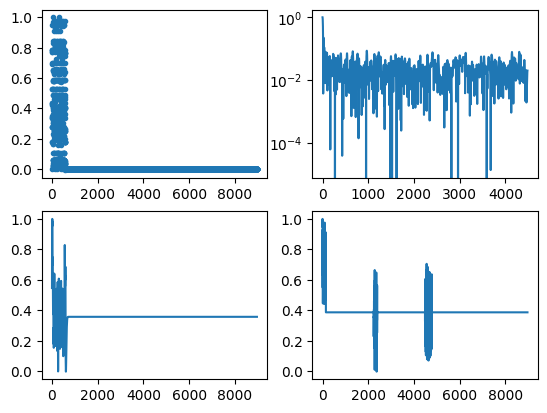

In [18]:
from numba import njit, jit
import pywt
from scipy.fft import fft, fftfreq
from scipy import signal

#@jit()# @jit(nopython=True, parallel=True)
def normalize(arrin, t_min, t_max):
    arr = np.array(arrin,dtype=np.float32)
    try:
        X_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) - 1.
    except ZeroDivisionError:
        print('div by 0')
        X_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) - 1.
    norm_arr = X_std * ((t_max - (t_min))+0.001) + t_max
    return norm_arr

# @jit(nopython=True, parallel=True)
# def norm_2d(x):
#     xmax = np.max(x)
#     return np.linalg.norm(x / xmax) * xmax

def norm_2d(sample_transformed):
    sample_transformed /= np.max(np.abs(sample_transformed),axis=0)
    return sample_transformed


def flatten_list(l):
    return [item for sublist in l for item in sublist]
#choosen_sample = np.delete(train[200][0],[0])
choosen_sample =train[2][0] # orginal signal
sample_transformed = choosen_sample
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
N = len(choosen_sample)
T = 1.0 / len(choosen_sample)
sample_transformed /= np.max(np.abs(sample_transformed),axis=0)
ax1.plot(sample_transformed,'.')
yfreq = fft(choosen_sample) # Fourier transform
xfreq = fftfreq(N, T)[:N//2]
ax2.semilogy(xfreq, normalize(2.0/N * np.abs(yfreq[0:N//2]),0,1))
widths = np.arange(1, 31)
wavelet = signal.ricker # only option unfortunately
#cwtmatr = signal.cwt(choosen_sample , wavelet, widths) # Continuous Wavelet Transform
cwtmatr, freqs = pywt.cwt(choosen_sample, widths, 'mexh') # Continuous Wavelet Transform # 'gaus1'
print(cwtmatr.shape)
coeffArray = pywt.wavedec(choosen_sample,'db1',level=2)  # Multilevel discrete Wavelet transform
#print(coeffArray)
# ax3.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='seismic', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
cwtmatr_sum = cwtmatr[0][:]
for i in range(1,len(cwtmatr)-1):
    cwtmatr_sum += cwtmatr[i][:]

ax3.plot(normalize(cwtmatr_sum,0,1))
print(cwtmatr_sum.shape)
dwt_coeffs = flatten_list(coeffArray)
ax4.plot(normalize(dwt_coeffs,0,1))


plt.show()

In [45]:
fft_train = []
cwt_train = []
dwt_train = []
cwtwavelet = 'mexh'
dwtwavelet = 'db1'
w2_wavelet = 31
level = 2
widths = np.arange(1, w2_wavelet) # can be changed to optimize learning
for i in range(0,len(train)):
    choosen_sample =train[i][0]
    yfreq = fft(choosen_sample)
    N = 20000
    T = 1.0 / len(choosen_sample)
    fft_train.append(2.0/N * np.abs(yfreq[0:N//2]))
    cwtmatr, freqs = pywt.cwt(choosen_sample, widths,cwtwavelet)
    cwt_train.append(cwtmatr)
    coeffArray = pywt.wavedec(choosen_sample,dwtwavelet,level=level)
    dwt_coeffs = flatten_list(coeffArray)
    dwt_train.append(dwt_coeffs)
    #print(i)

print(len(fft_train[0]),len(train[0][0]),len(cwt_train[:][0]),len(dwt_train[0]))

8966 <class 'numpy.ndarray'> 30 8967


In [49]:
fft_test_no_target = []
cwt_test_no_target = []
dwt_test_no_target = []
for i in range(0,len(test_no_target)):
    choosen_sample =test_no_target[i]
    yfreq = fft(choosen_sample)
    N = 20000
    T = 1.0 / len(choosen_sample)
    fft_test_no_target.append(2.0/N * np.abs(yfreq[0:N//2]))
    cwtmatr, freqs = pywt.cwt(choosen_sample, widths,cwtwavelet)
    cwt_test_no_target.append(cwtmatr)
    coeffArray = pywt.wavedec(choosen_sample,dwtwavelet,level=level)
    dwt_coeffs = flatten_list(coeffArray)
    dwt_test_no_target.append(dwt_coeffs)

print(len(fft_test_no_target[0]),len(test_no_target[0][0]),len(cwt_test_no_target[:][0]),len(dwt_test_no_target[0]))

TypeError: object of type 'numpy.float32' has no len()

In [22]:
#np.seterr(divide='ignore', invalid='ignore')

data = [0. for _ in range(len(train))]
data_fft = [0. for _ in range(len(fft_train))]
data_targets = [0. for _ in range(len(train))]
data_cwt_sum = [0. for _ in range(len(train))]

# print(np.array(np.sum(cwt_train[0][:],axis=0)).shape)
for i in range(len(train)):
    data[i] = np.array(train[i][0],dtype=np.float32)
    data_fft[i] = np.array(fft_train[i],dtype=np.float32)
    dwt_train[i] = np.array(dwt_train[i],dtype=np.float32)
    data_cwt_sum[i] = np.array(np.sum(cwt_train[i][:],axis=0),dtype=np.float32)
    data_targets[i] = np.array(train[i][1],dtype=np.float32)

values, counts = np.unique(np.array(data_targets), return_counts=True)
#
# #print(data[0],data_fft[0].real,data_fft[0].imag,"\n",counts)
#

train_data_set = []

for i in range(0,len(data)):
    # print(data[i].shape,data_fft[i].real.shape,data_fft[i].imag.shape,data_cwt_sum[i].shape,dwt_train[i][0:-1].shape)
    train_data_set.append(np.array((data[i],data_fft[i].real,data_fft[i].imag,cwt_train[i][0],cwt_train[i][15],cwt_train[i][29],dwt_train[i][0:-1]),dtype=np.float32))


#data_cwt_sum[i] # probably could be better after normalization of some kind

In [57]:
data_test_no_target = [0. for _ in range(len(test_no_target))]
data_fft_test_no_target = [0. for _ in range(len(fft_test_no_target))]
# print(np.array(np.sum(cwt_train[0][:],axis=0)).shape)
print(test_no_target[0].shape)
for i in range(len(test_no_target)):
    data_test_no_target[i] = np.array(test_no_target[i],dtype=np.float32)
    data_fft_test_no_target[i] = np.array(fft_test_no_target[i],dtype=np.float32)
    dwt_test_no_target[i] = np.array(dwt_test_no_target[i],dtype=np.float32)

test_no_target_data_set = []

for i in range(0,len(data_test_no_target)):
    # print(data_test_no_target[i].shape,data_fft_test_no_target[i].real.shape,data_fft_test_no_target[i].imag.shape,cwt_test_no_target[i][0].shape,cwt_test_no_target[i][15].shape,cwt_test_no_target[i][29].shape,dwt_train[i][0:-1].shape)

    test_no_target_data_set.append(np.array((data_test_no_target[i],data_fft_test_no_target[i].real,data_fft_test_no_target[i].imag,cwt_test_no_target[i][0],cwt_test_no_target[i][15],cwt_test_no_target[i][29],dwt_test_no_target[i][0:-1]),dtype=np.float32))


#data_cwt_sum[i] # probably could be better after normalization of some kind

(8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) (8966,) (8966,)
(8966,) (8966,) (8966,) (8966,) (8966,) 

In [61]:
torch.manual_seed(2022)

train_data = torch.FloatTensor(np.array(train_data_set))
train_targets = torch.FloatTensor(np.array(data_targets))
test_indices = torch.randperm(len(train_data))[:int(len(train_data)*0.2)]
sorted, indices_sorted = torch.sort(test_indices )
train_indecies = []

m = 0
for i in range(0,len(train_data)-2):
    index = int(np.array(sorted[m]))
    if  index == i:
        m+=1
    else:
        train_indecies.append(i)



test_data = train_data[test_indices]
test_targets = train_targets[test_indices]
ttrain_data = train_data[train_indecies]
ttrain_targets = train_targets[train_indecies]

In [62]:
train_set = torch.utils.data.TensorDataset(ttrain_data, ttrain_targets)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)   #
test_set = torch.utils.data.TensorDataset(test_data, test_targets)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [84]:
import torch.nn.functional as F

class RecurentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size,bidirectional = True):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        # self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.conv0 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3,3),padding=1)
        self.layer_norm0 = torch.nn.LayerNorm([16, 1, 8966], elementwise_affine=True)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3),padding=1)
        #self.bn0 = nn.BatchNorm2d(32)
        self.layer_norm1 = torch.nn.LayerNorm([32, 1, 8966], elementwise_affine=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=(3,3),padding=1)
        self.layer_norm2 = torch.nn.LayerNorm([64, 1, 8966], elementwise_affine = True)
        #self.bn1 = nn.BatchNorm2d(64)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,bidirectional = bidirectional, dropout=0.3, batch_first=False)

        self.conv3 = nn.Conv2d(in_channels=hidden_size*self.bidirectional,out_channels=hidden_size,kernel_size=(3,3),padding=1)
        self.fc0 = nn.Linear(hidden_size*self.bidirectional, hidden_size*self.bidirectional)
        self.fc1 = nn.Linear(hidden_size*self.bidirectional, out_size)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=np.sqrt(6)/np.sqrt(self.input_size))
            if module.bias is not None:
                module.bias.data.zero_()


    def init_hidden(self, batch_size):
        h_t = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size,dtype=torch.float32)
        c_t = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size,dtype=torch.float32)
        return h_t, c_t

    def forward(self, x, h_t,c_t):
        #print("1:",x.size())
        x = F.relu(self.conv0(x))
        x = self.layer_norm0(x)
        #print("1n:",x.size())
        x = F.dropout(F.relu(self.conv1(x)),p=0.3)
        #print("1m:",x.size())
        x = self.layer_norm1(x)
        x = F.dropout(F.relu(self.conv2(x)),p=0.3)
        #x = F.relu(self.bnorm0(x))
        #print("2:",x.size())
        x = self.layer_norm2(x)
        # x = x.squeeze(1)
        x = x.squeeze(2)
        #print("3:",x.size())
        x = torch.transpose(x,2,1)
        #print("4:",x.size())
        x = torch.transpose(x,0,1)
        #print("5:",x.size())
        h_t,c_t = self.lstm(x, (h_t,c_t))
        #print("6:",x.size())
        #print("h1:",h_t.size())
        x = torch.transpose(h_t,0,1)
        #x = self.conv3(x)
        #print("7:",x.size())
        #print("8:",x.size())
        x = x[:,-1]
        #print("9:",x.size())
        x = self.fc0(x)
        #print("10:",x.size())
        x = self.fc1(x)
        #print("11:",x.size())
        return x, (h_t,c_t)

model = RecurentClassifier(64,25,3,out_size=5).to(device)

# LOAD WHOLE MODEL
#PATH = "entire_model.pt"
# model = torch.load(PATH)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
torch.cuda.empty_cache()
# 9 best 81%

RecurentClassifier(
  (conv0): Conv2d(7, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_norm0): LayerNorm((16, 1, 8966), eps=1e-05, elementwise_affine=True)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_norm1): LayerNorm((32, 1, 8966), eps=1e-05, elementwise_affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_norm2): LayerNorm((64, 1, 8966), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(64, 75, num_layers=3, dropout=0.3, bidirectional=True)
  (conv3): Conv2d(150, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc0): Linear(in_features=150, out_features=150, bias=True)
  (fc1): Linear(in_features=150, out_features=5, bias=True)
)
2514274


In [64]:
@torch.no_grad()
def eval_test(model,loader):
    total, correct = 0., 0.
    model.eval()
    for x, targets in loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        #targets = targets.view(len(targets), 5).long()
        h_t, c_t = model.init_hidden(x.size(0))
        h_t, c_t = h_t.to(device), c_t.to(device)
        preds, _ = model(x, h_t, c_t)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets.long())
        with torch.no_grad():
            _, predicted_class = torch.max(preds, 1)
            total += targets.size(0)
            correct += (predicted_class == targets).sum().item()
    acc = correct / total
    return loss, acc

Epoch: 0, loss: 1.22,test_loss: 0.991
Training accuracy 41.73543%, test_accuracy 46.50000%
Epoch: 1, loss: 1.13,test_loss: 0.94
Training accuracy 49.14979%, test_accuracy 49.55000%
Epoch: 2, loss: 1.2,test_loss: 1.0
Training accuracy 50.80020%, test_accuracy 54.65000%
Epoch: 3, loss: 1.2,test_loss: 0.957
Training accuracy 52.75069%, test_accuracy 54.80000%
Epoch: 4, loss: 1.02,test_loss: 0.777
Training accuracy 53.15079%, test_accuracy 52.05000%
Epoch: 5, loss: 1.35,test_loss: 0.979
Training accuracy 53.46337%, test_accuracy 55.30000%
Epoch: 6, loss: 0.75,test_loss: 0.822
Training accuracy 54.33858%, test_accuracy 56.70000%
Epoch: 7, loss: 0.761,test_loss: 0.757
Training accuracy 57.21430%, test_accuracy 60.95000%
Epoch: 8, loss: 0.897,test_loss: 0.64
Training accuracy 62.27807%, test_accuracy 64.75000%
Epoch: 9, loss: 0.793,test_loss: 0.733
Training accuracy 65.89147%, test_accuracy 67.45000%
Epoch: 10, loss: 0.829,test_loss: 0.663
Training accuracy 68.27957%, test_accuracy 68.70000%


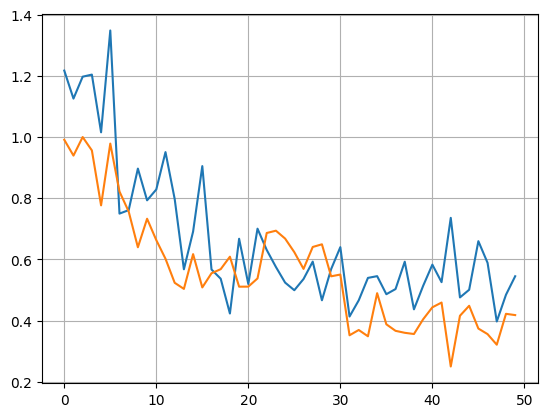

In [85]:
from torch import optim

optimizer = torch.optim.Adam(model.parameters(),weight_decay=2e-3, lr = 1e-3,amsgrad=True)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fun = nn.CrossEntropyLoss()
# Training loop

k = 0
train_loss_list = []
ttrain_acc = []
test_loss_list = []
ttest_acc = []
iter_list = []
PATH = "entire_model12.pt"

for epoch in range(25):
    total, correct = 0., 0.
    for x, targets in train_loader:
        model.train()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        #targets = targets.view(len(targets), 5).long()
        h_t, c_t = model.init_hidden(x.size(0))
        h_t, c_t = h_t.to(device), c_t.to(device)
        preds, _ = model(x, h_t, c_t)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets.long())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, predicted_class = torch.max(preds, 1)
            total += targets.size(0)
            correct += (predicted_class == targets).sum().item()
    tloss,tacc = eval_test(model,test_loader)


    #scheduler.step()
    train_loss_list.append(loss.item())
    test_loss_list.append(tloss.item())
    iter_list.append(k)
    k +=1
    train_acc = correct / total
    ttrain_acc.append(train_acc)
    ttest_acc.append(tacc)
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch}, loss: {loss.item():.3},test_loss: {tloss.item():.3}")
    print(f"Training accuracy {train_acc:.5%}, test_accuracy {tacc:.5%}")
    if epoch > 1:
        if ttrain_acc[epoch-1] < ttrain_acc[epoch] and ttest_acc[epoch-1] < ttest_acc[epoch]:
            torch.save(model, PATH)

plt.plot(iter_list,train_loss_list)
plt.plot(iter_list,test_loss_list)
plt.grid()
plt.show()
torch.cuda.empty_cache()